In [2]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from PIL import Image, ImageStat

# Modeling Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Flatten, Input, Conv2D, 
                                     MaxPooling2D, BatchNormalization, 
                                     Dropout, Add, Activation,
                                     AveragePooling2D,
                                     GlobalAveragePooling2D)
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             accuracy_score, precision_score)
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append(os.path.join(os.pardir, os.pardir, 'src'))
import functions as fx

In [3]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256), 
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256),
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [5]:
# Calculate weights to balance perennial and weed data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

# Stop training if loss does not decrease in 5 epochs
early_stop_loss = EarlyStopping(monitor = 'loss', patience = 5, restore_best_weights = True)

In [6]:
def LeNet5(image):
    
    layers = [
        Input(image.shape),
        Conv2D(6, (5, 5), activation = 'relu'),
        AveragePooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        AveragePooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(82, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [7]:
model_LeNet5 = LeNet5(train_generator[0][0][0])
model_LeNet5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 61, 61, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59536)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               7144440   
_________________________________________________________________
dense_1 (Dense)              (None, 82)                9

In [8]:
result_LeNet5 = model_LeNet5.fit(train_generator, epochs = 50, validation_data=val_generator,
                                 class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 89s 1s/step - loss: 0.7456 - accuracy: 0.6094 - precision: 0.6752 - val_loss: 0.7829 - val_accuracy: 0.5873 - val_precision: 0.7524
Epoch 2/50
74/74 [==============================] - 86s 1s/step - loss: 0.5885 - accuracy: 0.7033 - precision: 0.7320 - val_loss: 0.6073 - val_accuracy: 0.6871 - val_precision: 0.7108
Epoch 3/50
74/74 [==============================] - 86s 1s/step - loss: 0.5315 - accuracy: 0.7305 - precision: 0.7469 - val_loss: 0.6117 - val_accuracy: 0.7025 - val_precision: 0.7364
Epoch 4/50
74/74 [==============================] - 85s 1s/step - loss: 0.5292 - accuracy: 0.7388 - precision: 0.7573 - val_loss: 0.6632 - val_accuracy: 0.6603 - val_precision: 0.6553
Epoch 5/50
74/74 [==============================] - 86s 1s/step - loss: 0.5141 - accuracy: 0.7446 - precision: 0.7575 - val_loss: 0.6364 - val_accuracy: 0.6622 - val_precision: 0.6544
Epoch 6/50
74/74 [==============================] - 86s 1s/step - loss: 0.5060 -

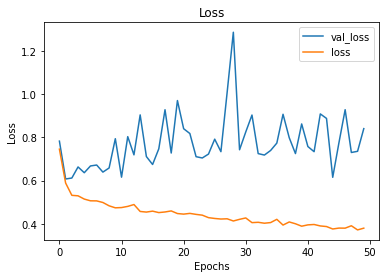

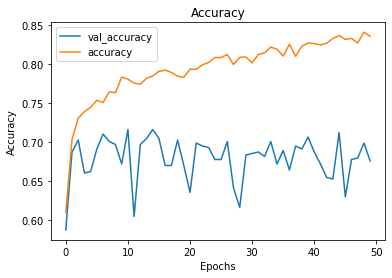

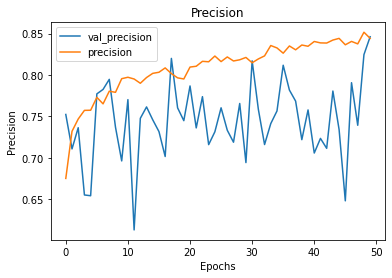

In [9]:
fx.visualize_training_results(result_LeNet5)

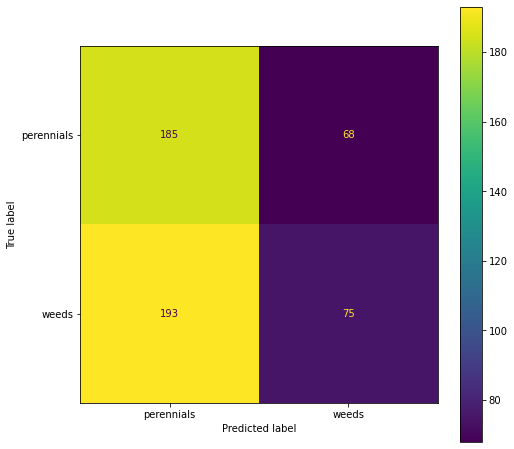

In [10]:
fx.create_confusion_matrix(model_LeNet5, val_generator)

In [11]:
fx.get_metrics(model_LeNet5, val_generator)

Accuracy: 0.46449136276391556
Precision: 0.46153846153846156


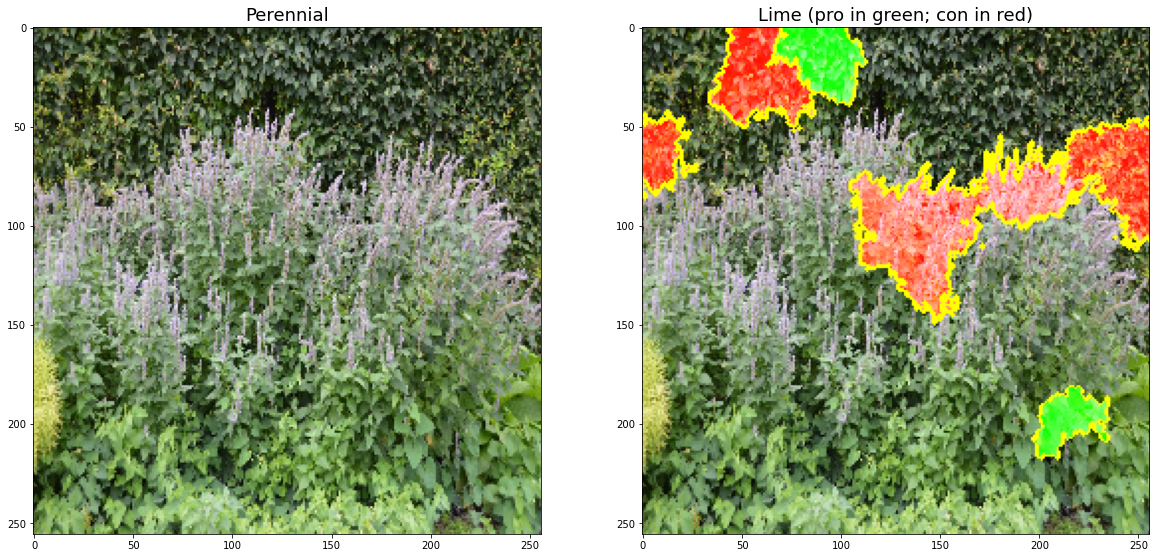

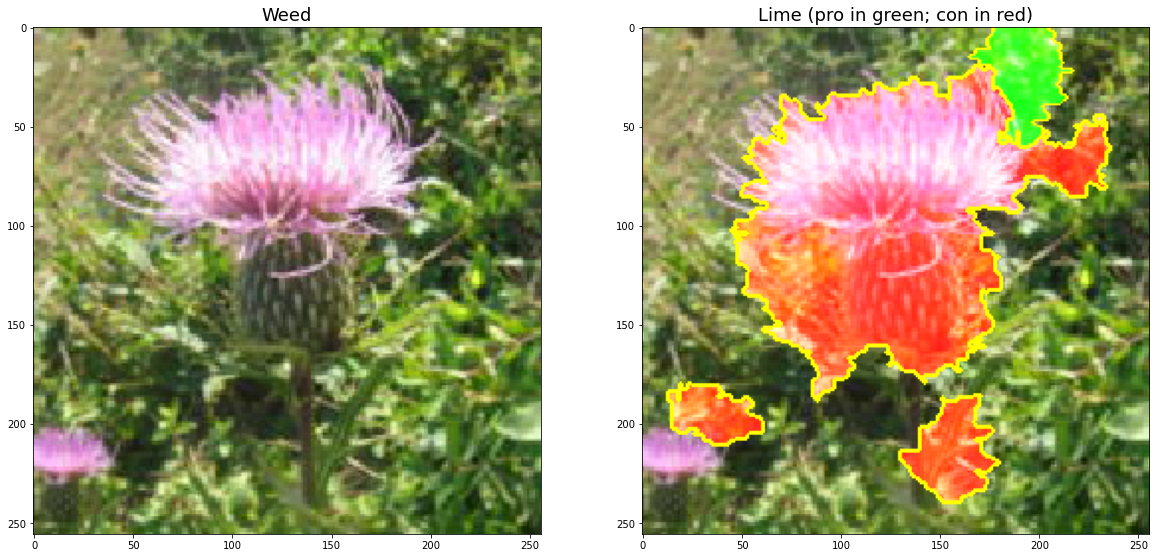

In [12]:
fx.display_lime(model_LeNet5, val_generator)

In [8]:
def AlexNet(image):
    
    layers = [
        Input(image.shape),
        Conv2D(96, (11,11), activation = 'relu'),
        BatchNormalization(),
        MaxPooling2D((3,3)),
        Conv2D(256, (5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3,3)),
        Conv2D(384, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(384, (3,3), activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3,3)),
        Flatten(),
        Dense(9216, activation='relu'),
        Dropout(.5),
        Dense(4096, activation='relu'),
        Dropout(.5),
        Dense(4096, activation='relu'),
        Dropout(.5),
        Dense(1, activation='sigmoid')
    ]
    
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [9]:
model_AlexNet = AlexNet(train_generator[0][0][0])
model_AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 246, 246, 96)      34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 246, 246, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 82, 82, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 82, 82, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 384)       8

In [10]:
result_AlexNet = model_AlexNet.fit(train_generator, epochs = 50, validation_data=val_generator,
                                   class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 789s 11s/step - loss: 7.2638 - accuracy: 0.5187 - precision: 0.5334 - val_loss: 1.3384 - val_accuracy: 0.5106 - val_precision: 0.5131
Epoch 2/50
74/74 [==============================] - 786s 11s/step - loss: 0.8303 - accuracy: 0.5326 - precision: 0.5476 - val_loss: 0.6758 - val_accuracy: 0.5739 - val_precision: 0.5612
Epoch 3/50
74/74 [==============================] - 787s 11s/step - loss: 0.7358 - accuracy: 0.5598 - precision: 0.5755 - val_loss: 0.6823 - val_accuracy: 0.5950 - val_precision: 0.5729
Epoch 4/50
74/74 [==============================] - 788s 11s/step - loss: 0.7021 - accuracy: 0.5932 - precision: 0.6062 - val_loss: 0.7156 - val_accuracy: 0.5182 - val_precision: 0.5170
Epoch 5/50
74/74 [==============================] - 785s 11s/step - loss: 0.6835 - accuracy: 0.5983 - precision: 0.6138 - val_loss: 0.6725 - val_accuracy: 0.5221 - val_precision: 0.8519
Epoch 6/50
74/74 [==============================] - 782s 11s/step - lo

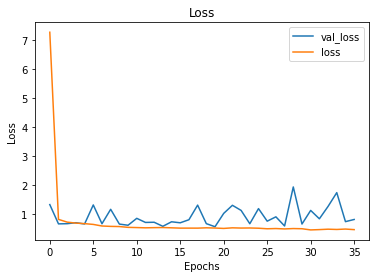

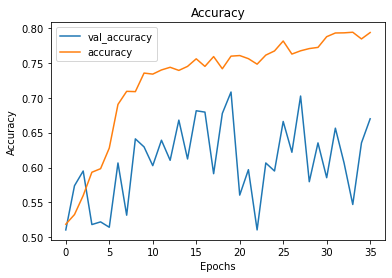

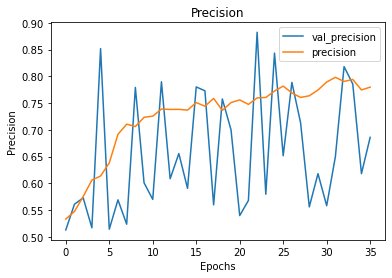

In [11]:
fx.visualize_training_results(result_AlexNet)

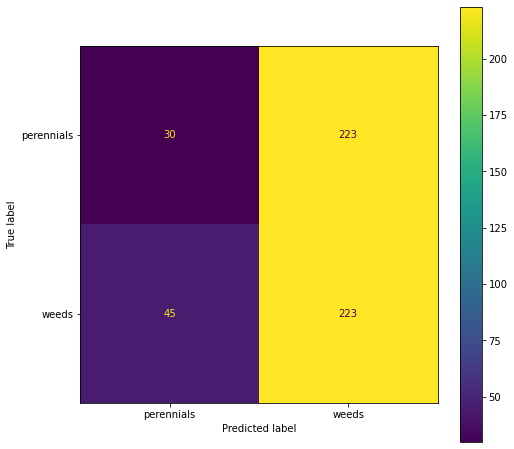

In [12]:
fx.create_confusion_matrix(model_AlexNet, val_generator)

In [13]:
fx.get_metrics(model_AlexNet, val_generator)

Accuracy: 0.4856046065259117
Precision: 0.5


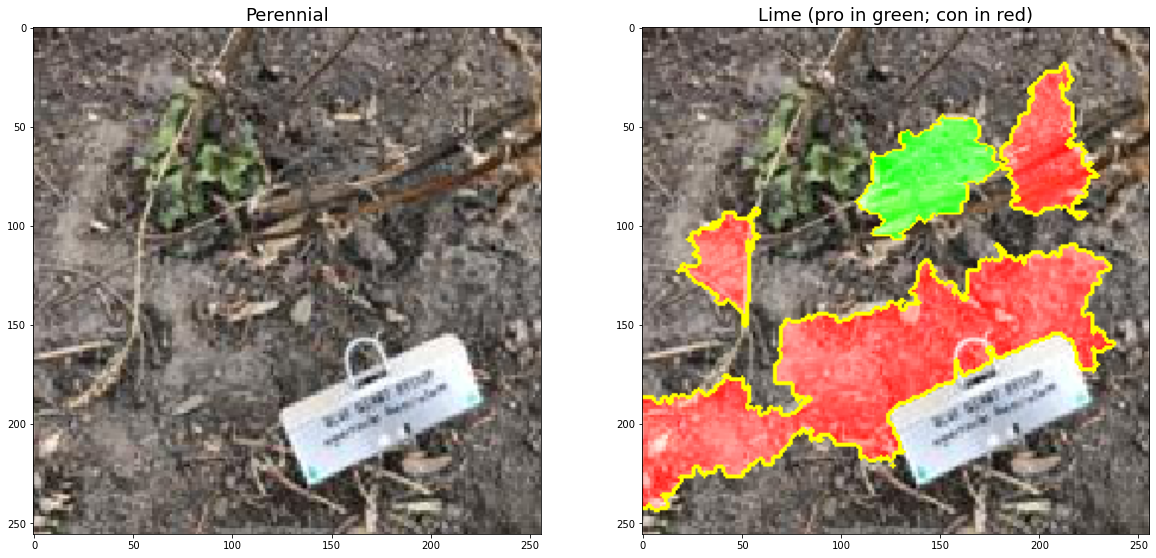

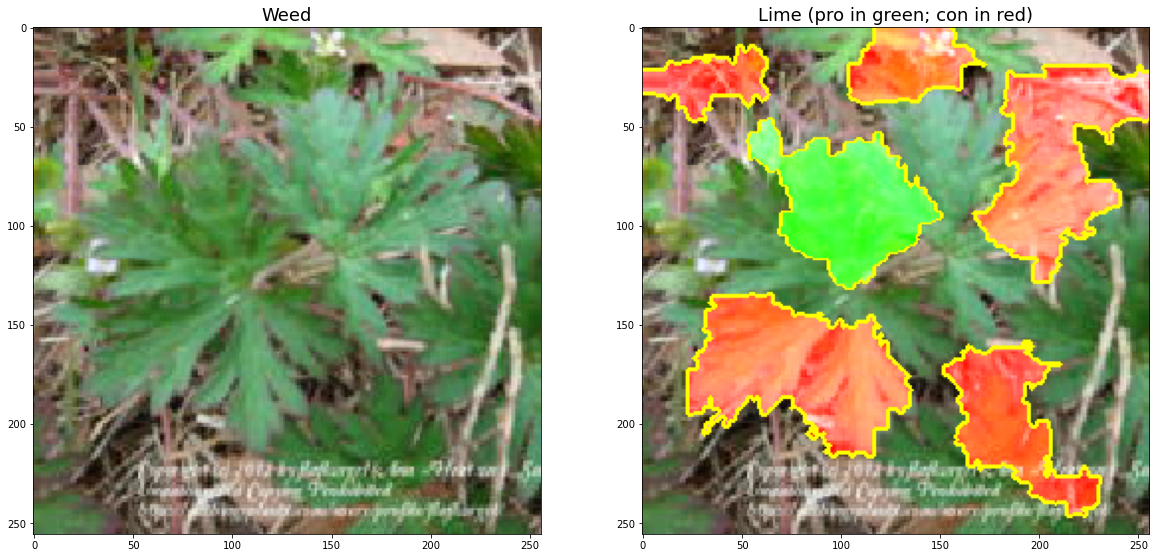

In [14]:
fx.display_lime(model_AlexNet, val_generator)

In [18]:
def SimpleResNet(image):

    input_layer = Input(image.shape)
   
    X = Conv2D(64, (3,3), activation='relu')(input_layer)
    X = BatchNormalization()(X)
    
    X_shortcut = X

    X = Conv2D(64, (3,3), padding='same', activation='relu')(X)
    X = BatchNormalization()(X)

    X = Add()([X, X_shortcut] )# Skip Connection
    X = Activation('relu')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=input_layer, outputs=X, name='ResNet')
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    
    return model 

In [19]:
model_SimpleResNet = SimpleResNet(train_generator[0][0][0])
model_SimpleResNet.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 254, 254, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 254, 254, 64) 256         conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 254, 254, 64) 36928       batch_normalization_5[0][0]      
_____________________________________________________________________________________________

In [20]:
result_SimpleResNet = model_SimpleResNet.fit(train_generator, epochs = 50, validation_data=val_generator,
                                             class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 478s 6s/step - loss: 80.7804 - accuracy: 0.6090 - precision: 0.6285 - val_loss: 2.9031 - val_accuracy: 0.5240 - val_precision: 0.5202
Epoch 2/50
74/74 [==============================] - 477s 6s/step - loss: 35.4484 - accuracy: 0.6352 - precision: 0.6491 - val_loss: 1.9998 - val_accuracy: 0.5240 - val_precision: 0.5228
Epoch 3/50
74/74 [==============================] - 480s 6s/step - loss: 25.5559 - accuracy: 0.6669 - precision: 0.6783 - val_loss: 1.1111 - val_accuracy: 0.5912 - val_precision: 0.6000
Epoch 4/50
74/74 [==============================] - 483s 7s/step - loss: 21.0163 - accuracy: 0.6686 - precision: 0.6834 - val_loss: 11.8280 - val_accuracy: 0.5240 - val_precision: 0.5195
Epoch 5/50
74/74 [==============================] - 482s 7s/step - loss: 16.2788 - accuracy: 0.6790 - precision: 0.6935 - val_loss: 5.6533 - val_accuracy: 0.5701 - val_precision: 0.5759
Epoch 6/50
74/74 [==============================] - 486s 7s/step - lo

Epoch 45/50
74/74 [==============================] - 515s 7s/step - loss: 0.4297 - accuracy: 0.8135 - precision: 0.8000 - val_loss: 5.7347 - val_accuracy: 0.5969 - val_precision: 0.5636
Epoch 46/50
74/74 [==============================] - 488s 7s/step - loss: 0.4215 - accuracy: 0.8225 - precision: 0.8135 - val_loss: 1.9711 - val_accuracy: 0.6161 - val_precision: 0.6030
Epoch 47/50
74/74 [==============================] - 480s 6s/step - loss: 0.4202 - accuracy: 0.8265 - precision: 0.8115 - val_loss: 1.8547 - val_accuracy: 0.6200 - val_precision: 0.6006
Epoch 48/50
74/74 [==============================] - 482s 7s/step - loss: 0.4268 - accuracy: 0.8199 - precision: 0.8073 - val_loss: 2.3624 - val_accuracy: 0.5893 - val_precision: 0.5718
Epoch 49/50
74/74 [==============================] - 479s 6s/step - loss: 0.4318 - accuracy: 0.8235 - precision: 0.8064 - val_loss: 5.4327 - val_accuracy: 0.5509 - val_precision: 0.5339
Epoch 50/50
74/74 [==============================] - 481s 6s/step - lo

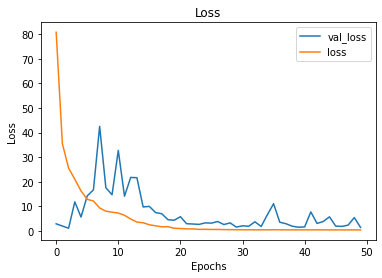

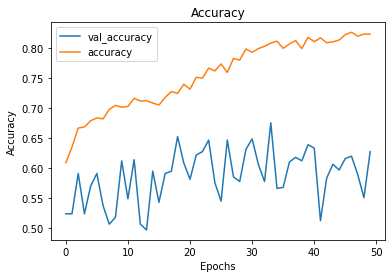

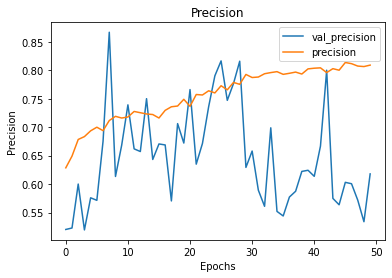

In [21]:
fx.visualize_training_results(result_SimpleResNet)

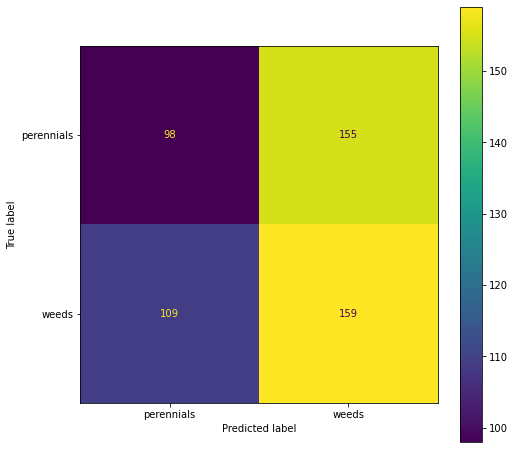

In [22]:
fx.create_confusion_matrix(model_SimpleResNet, val_generator)

In [23]:
fx.get_metrics(model_SimpleResNet, val_generator)

Accuracy: 0.5009596928982726
Precision: 0.5127388535031847


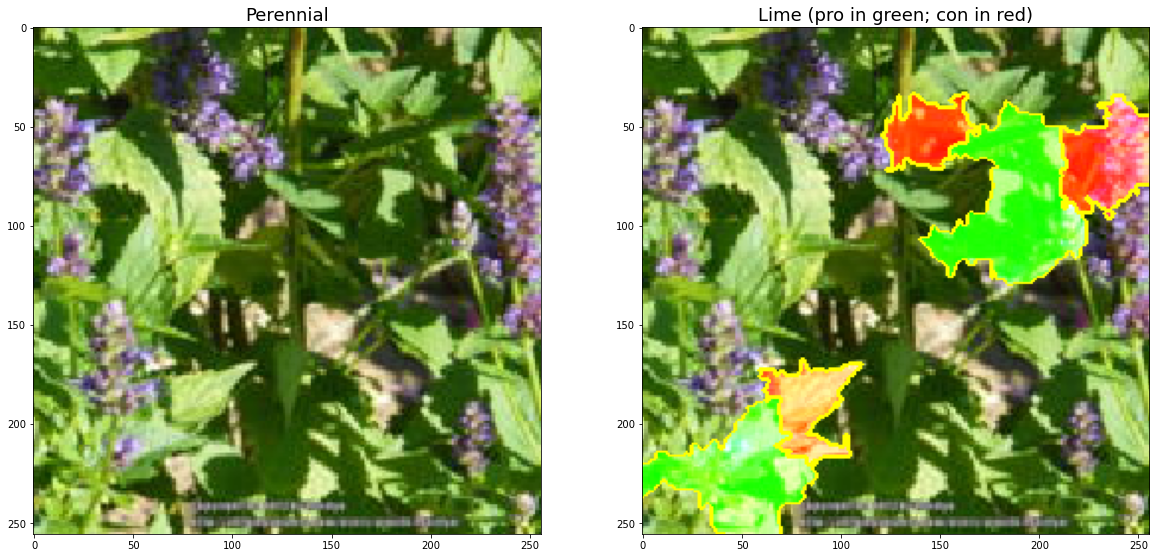

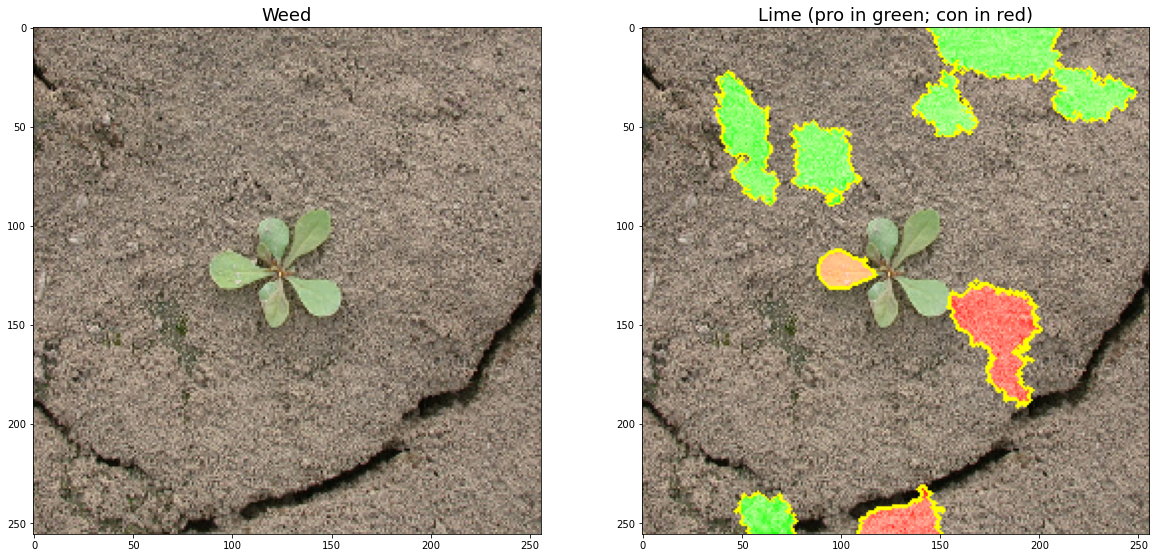

In [24]:
fx.display_lime(model_SimpleResNet, val_generator)

In [25]:
def CustomResNet50(image):
    base_model = ResNet50(include_top = False, weights = None, input_shape = image.shape)
    
    X = base_model.output
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation = 'sigmoid')(X)
    
    model = Model(inputs = base_model.input, outputs = X)
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Recall'])
    return model

In [26]:
model_CustomResNet50 = CustomResNet50(train_generator[0][0][0])
model_CustomResNet50.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [27]:
result_CustomResNet50 = model_CustomResNet50.fit(train_generator, epochs = 50, validation_data=val_generator,
                                             class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/50
74/74 [==============================] - 857s 12s/step - loss: 0.8188 - accuracy: 0.6628 - recall: 0.6840 - val_loss: 0.7274 - val_accuracy: 0.5144 - val_recall: 1.0000
Epoch 2/50
74/74 [==============================] - 857s 12s/step - loss: 0.6425 - accuracy: 0.6954 - recall: 0.7344 - val_loss: 0.8799 - val_accuracy: 0.5125 - val_recall: 0.9963
Epoch 3/50
74/74 [==============================] - 855s 12s/step - loss: 0.6190 - accuracy: 0.7073 - recall: 0.7336 - val_loss: 0.9900 - val_accuracy: 0.5144 - val_recall: 1.0000
Epoch 4/50
74/74 [==============================] - 856s 12s/step - loss: 0.6277 - accuracy: 0.7143 - recall: 0.7534 - val_loss: 0.9719 - val_accuracy: 0.5413 - val_recall: 0.9888
Epoch 5/50
74/74 [==============================] - 855s 12s/step - loss: 0.5910 - accuracy: 0.7212 - recall: 0.7406 - val_loss: 95.3583 - val_accuracy: 0.4875 - val_recall: 0.0037
Epoch 6/50
74/74 [==============================] - 862s 12s/step - loss: 0.5501 - accuracy: 0.7401

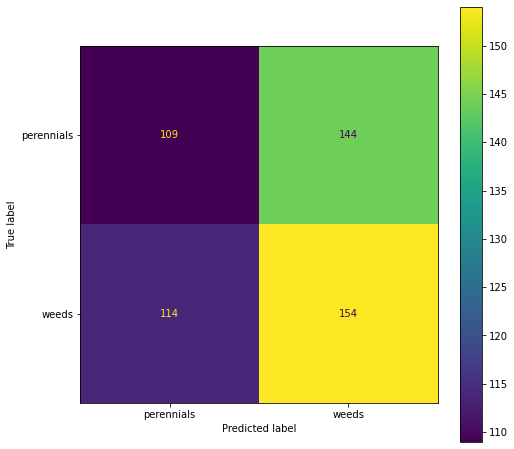

In [29]:
fx.create_confusion_matrix(model_CustomResNet50, val_generator)

In [30]:
fx.get_metrics(model_CustomResNet50, val_generator)

Accuracy: 0.4971209213051823
Precision: 0.5100671140939598


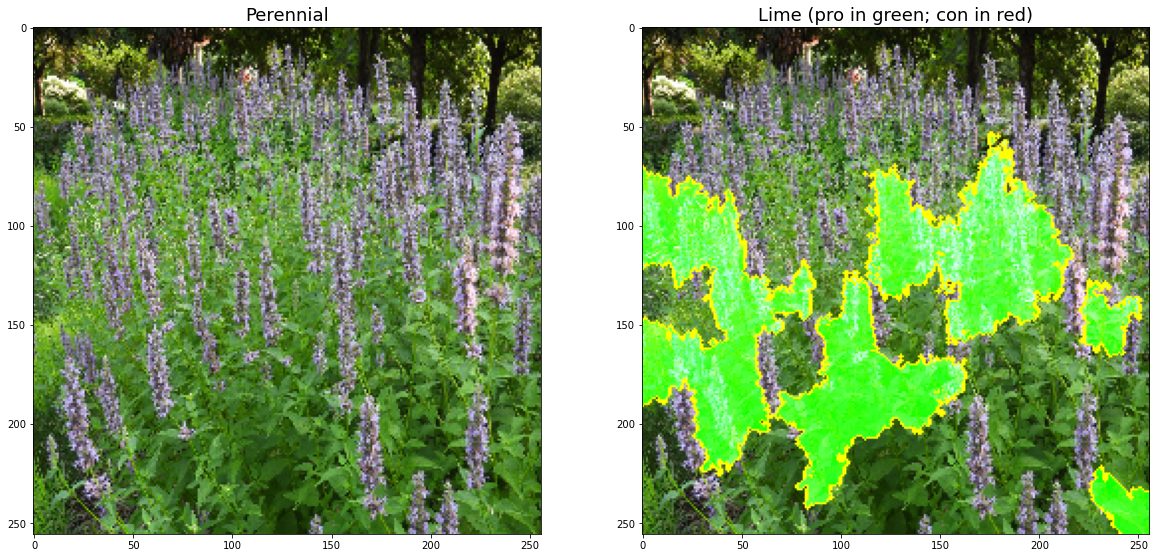

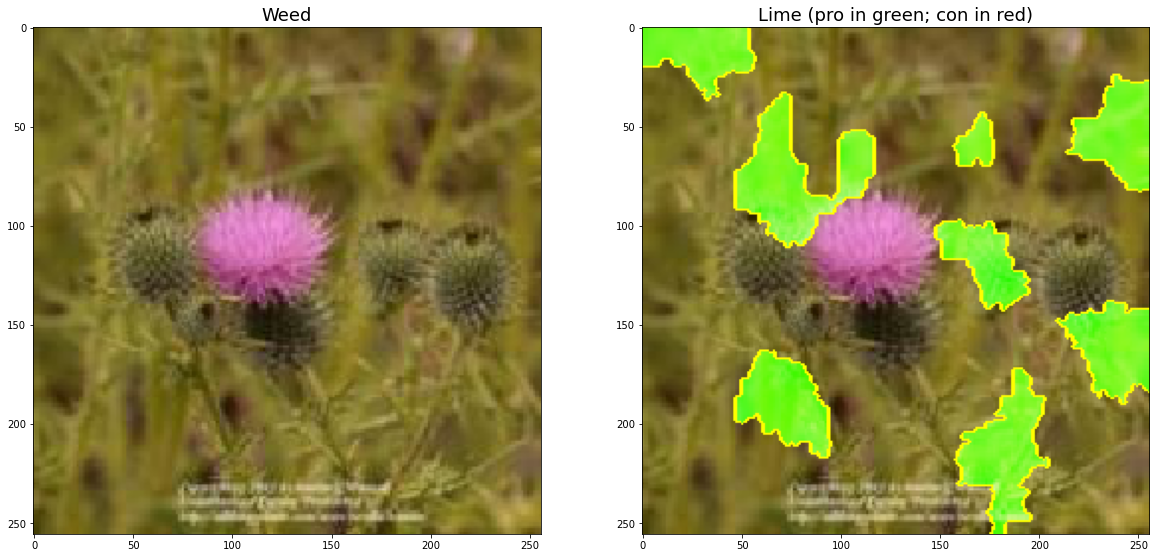

In [31]:
fx.display_lime(model_CustomResNet50, val_generator)